In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from comet_ml import Experiment

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mnist_transforms = transforms.Compose([ # Compose combines a number of transforms into one operation
    transforms.ToTensor(), # PIL Image -> Tensor
    transforms.Normalize([0.5], [0.5]) # input = (input - 0.5) / 0.5 -> x \sim input \in [-1, 1]
])

In [8]:
# We can use torchvision package to get MNIST dataset

data_path = "../data/"

train_dataset = datasets.MNIST(data_path,
                               train=True,
                               transform=mnist_transforms,
                               target_transform=None,
                               download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)


0it [00:00, ?it/s]

9920512it [00:02, 3469524.51it/s]                             


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


32768it [00:00, 210995.61it/s]           
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


1654784it [00:01, 1270337.57it/s]                             
8192it [00:00, 82860.64it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


Label: 3


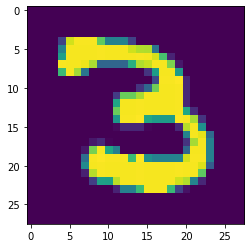

In [9]:
img, label = next(iter(train_loader))
print(f'Label: {label[0]}')
plt.imshow(img[0, 0, :,:])
plt.show()

Our goal is to build a GAN composed of two different modules, namely Generator and Discriminator. 

1. The Generator takes a noise from a latent space and outputs an image (1x28x28). The goal is to "fool" the Discriminator 
2. The Discriminator takes an image (1x28x28) and returns a probability of the image being real. The goal is to distinguish real images from generated ones.

Using the binary cross enntropy loss we are minimizing the JS distance between the real and "generated" distribution, shifting "generated" images closer to the real ones. 

You can fing the original paper [here](https://www.arxiv-vanity.com/papers/1406.2661/)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.upsample = nn.Upsample(
            scale_factor=2,
            mode='bilinear',
            align_corners=True
        )
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), # 16x7x7
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            self.upsample, # 16x14x14
            nn.Conv2d(16, 32, 5, padding=2), # 32x14x14
            nn.BatchNorm2d(32), 
            nn.LeakyReLU(),
            self.upsample, # 32x28x28
            nn.Conv2d(32, 32, 5, padding=2), # 32x28x28
            nn.BatchNorm2d(32), 
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3, padding=1), # 32x28x28
            nn.BatchNorm2d(32), 
            nn.LeakyReLU(),
        )
        self.final_layers = nn.Sequential(
            nn.Conv2d(32, 1, 3, padding=1), # 1x28x28
            nn.Tanh(), # 1x28x28 \in [-1, 1]
        )
        
        
    def forward(self, x):
        x = x.view(x.size(0), 1, 7, 7)
        x = self.layers(x)
        return self.final_layers(x)

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, 7, stride=2, padding=3), # 16x14x14
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, 5, stride=2, padding=2), # 32x7x7
            nn.BatchNorm2d(32), 
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3, padding=1), # 32x7x7
            nn.BatchNorm2d(32), 
            nn.LeakyReLU(),
            nn.Conv2d(32, 1, 3, padding=1), # 1x7x7
            nn.LeakyReLU()
        )
        self.final_layers = nn.Sequential(
            nn.Linear(1*7*7, 1)
        )
    def forward(self,x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        return self.final_layers(x)

In [14]:
from torchsummary import summary

generator = Generator().to(device)
print(summary(generator, (7*7, )))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 16, 7, 7]             160
       BatchNorm2d-2             [-1, 16, 7, 7]              32
         LeakyReLU-3             [-1, 16, 7, 7]               0
          Upsample-4           [-1, 16, 14, 14]               0
          Upsample-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]          12,832
       BatchNorm2d-7           [-1, 32, 14, 14]              64
         LeakyReLU-8           [-1, 32, 14, 14]               0
          Upsample-9           [-1, 32, 28, 28]               0
         Upsample-10           [-1, 32, 28, 28]               0
           Conv2d-11           [-1, 32, 28, 28]          25,632
      BatchNorm2d-12           [-1, 32, 28, 28]              64
        LeakyReLU-13           [-1, 32, 28, 28]               0
           Conv2d-14           [-1, 32,

In [15]:
discriminator = Discriminator().to(device)
print(summary(discriminator, (1, 28, 28)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             800
       BatchNorm2d-2           [-1, 16, 14, 14]              32
         LeakyReLU-3           [-1, 16, 14, 14]               0
            Conv2d-4             [-1, 32, 7, 7]          12,832
       BatchNorm2d-5             [-1, 32, 7, 7]              64
         LeakyReLU-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 32, 7, 7]           9,248
       BatchNorm2d-8             [-1, 32, 7, 7]              64
         LeakyReLU-9             [-1, 32, 7, 7]               0
           Conv2d-10              [-1, 1, 7, 7]             289
        LeakyReLU-11              [-1, 1, 7, 7]               0
           Linear-12                    [-1, 1]              50
Total params: 23,379
Trainable params: 23,379
Non-trainable params: 0
---------------------------------

In [16]:
experiment = Experiment(api_key="lODeHEtCf7XLaV6DJrOfugNcA",
                        project_name="yandex-school-gan-mnist", workspace="holybayes")

LR = 0.001

optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR)

criterion = torch.nn.BCEWithLogitsLoss()

n_epochs = 10

def sample_noise(batch, dims, mean=0, std=0.1):
    z = nn.init.normal_(torch.zeros(batch, dims, device=device), mean=mean, std=std)
    return z

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/holybayes/yandex-school-gan-mnist/0b1c73e3175145a48770f61b2978a706



In [ ]:
sample_interval = 500

for epoch in tqdm(range(n_epochs), desc='Epoch loop'):
    for iter_ind, (imgs, _) in tqdm(enumerate(train_loader), desc='Train loop', leave=False):
        
        ones = torch.ones(imgs.size(0), 1, device=device)
        zeros = torch.zeros(imgs.size(0), 1, device=device)
        step = epoch * len(train_loader) + iter_ind
        
        # generator update
        optimizer_G.zero_grad()
        fake_imgs = generator(sample_noise(imgs.size(0), 7*7))
        loss_G = criterion(discriminator(fake_imgs), ones)
        loss_G.backward()
        optimizer_G.step()
        
        # discriminator update
        optimizer_D.zero_grad()
        fake_imgs = generator(sample_noise(imgs.size(0), 7*7))
        err_real = criterion(discriminator(imgs.to(device)), ones)
        err_fake = criterion(discriminator(fake_imgs), zeros)
        loss_D = err_real + err_fake
        loss_D.backward()
        optimizer_D.step()
        
        experiment.log_metrics({'Generator loss': loss_G.item(),
                                'Discriminator loss': loss_D.item()},
                                epoch = epoch,
                                step = step)        

        if step % sample_interval == 0:
            plt.figure(figsize = (10,10))

            plt.title(
                f"[Epoch {epoch}/{n_epochs}]" + \
                f"[Batch {step%len(train_loader)}/{len(train_loader)}]" + \
                f"[D loss: {loss_D.item()}] [G loss: {loss_G.item()}]"
            )
            
            experiment.log_image(make_grid(fake_imgs.data[:25]).cpu().detach().numpy()[0, :, :])

            plt.imshow(make_grid(fake_imgs.data[:25]).cpu().detach().numpy()[0, :, :])
            experiment.log_figure()
            plt.clf()
experiment.end()

KeyboardInterrupt: 

# *
Some usefull [tricks](https://github.com/soumith/ganhacks/blob/master/README.md) for training GAN's